In [1]:
import numpy as np
from datasets.graph import load_graph
from matplotlib import pyplot as plt

In [2]:
# This function opens a preprocessed graph and grabs all the phi_slope, z0 and truth info
def get_z0_phi_slope(fname):
    g = load_graph(fname)

    n_nodes = g.Ro[2]
    n_edges = g.Ro[3]
    X = g.X
    y = g.y
    Ro_flat = g.Ro[0][0][np.argsort(g.Ro[0][1])]           
    Ri_flat = g.Ri[0][0][np.argsort(g.Ri[0][1])]                       


    R_coordinate = np.zeros(n_nodes)
    R_coordinate[:] = 1000*X[:,0]

    Z_coordinate = np.zeros(n_nodes)
    Z_coordinate[:] = 1000*X[:,2]

    Phi_coordinate = np.zeros(n_nodes)
    Phi_coordinate[:] = np.pi*X[:,1]

    delta_R   = np.zeros(n_edges)
    delta_phi = np.zeros(n_edges)
    delta_Z = np.zeros(n_edges)
    Z0      = np.zeros(n_edges)

    for i in range(n_edges):
        delta_R[i] = R_coordinate[Ri_flat[i]] - R_coordinate[Ro_flat[i]]
        delta_Z[i] = Z_coordinate[Ri_flat[i]] - Z_coordinate[Ro_flat[i]]
        Z0[i]      = Z_coordinate[Ri_flat[i]] - R_coordinate[Ri_flat[i]] * delta_Z[i] / delta_R[i]
        delta_phi[i] = abs(Phi_coordinate[Ri_flat[i]] - Phi_coordinate[Ro_flat[i]])
        if delta_phi[i] > np.pi:
            delta_phi[i] = abs(delta_phi[i] - 2*np.pi)

    phi_slope = abs(delta_phi/delta_R)
#     phi_slope_true  = phi_slope[y > 0]
#     Z0_true  = abs(Z0[y > 0])
           
    return abs(Z0), phi_slope, y

In [3]:
# Loop over all the events and concatanate all the vectors into one large one
N_events = 100

for i in range(N_events):
    event_num = 1000 + i 
    fname = '/data/gnn_code/heptrkx-gnn-tracking/output/event00000' + str(event_num) + '_g000.npz'

    file_results = get_z0_phi_slope(fname)
    if i == 0:
        z0        = file_results[0]
        phi_slope = file_results[1]
        y         = file_results[2]
        
    else:
        z0        = np.append(z0,        file_results[0])
        phi_slope = np.append(phi_slope, file_results[1])
        y         = np.append(y,         file_results[2])

Text(0, 0.5, 'phi slope')

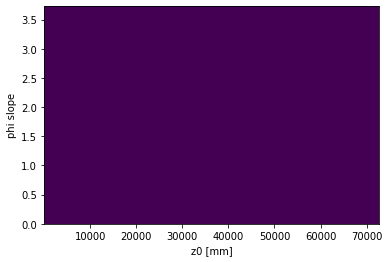

In [4]:
# Plot the truth distibutions
plt.hist2d(z0[y > 0], phi_slope[y > 0], 200)
plt.xlabel("z0 [mm]")
plt.ylabel("phi slope")

Text(0, 0.5, 'phi slope')

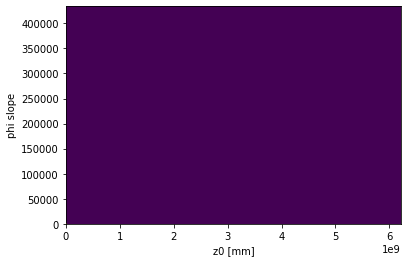

In [5]:
# Plot the truth distibutions
plt.hist2d(z0[y < 1], phi_slope[y < 1], 200)
plt.xlabel("z0 [mm]")
plt.ylabel("phi slope")

In [6]:
# Find the optimal z0 cut value for a given truth efficiency threshold
z0_true = z0[y > 0]
N_edges_true = len(z0_true)
threshold = .99
fraction = 0
cut = 0
while (fraction < threshold):
    cut += .001
    z0_cut_opt = z0_true[z0_true < cut]
    fraction = len(z0_cut_opt)/N_edges_true
print(cut, fraction)
z0_value = cut

17.42099999999831 0.9900045538653094


In [7]:
# Find the optimal phi slope cut value for a given truth efficiency threshold
phi_slope_true = phi_slope[y > 0]
N_edges_true = len(phi_slope_true)
threshold = .99
fraction = 0
cut = 0
while (fraction < threshold):
    cut += .0000001
    phi_cut_opt = phi_slope_true[phi_slope_true < cut]
    fraction = len(phi_cut_opt)/N_edges_true
print(cut, fraction)
phi_value = cut

0.00034570000000000754 0.9900045538653094


In [8]:
# Calculate the combined truth efficiency
# Want this value close to 1
z0_z0cut        = z0_true       [z0_true < z0_value]
phi_slope_z0cut = phi_slope_true[z0_true < z0_value]
N_edges_cut1 = len(z0_z0cut)
print('Using cut z0 < ' + str(z0_value))
# print('Remaining Fraction = ' + str(N_edges_cut1/N_edges_true))

z0_cut        = z0_z0cut       [phi_slope_z0cut < phi_value]
phi_slope_cut = phi_slope_z0cut[phi_slope_z0cut < phi_value]
N_edges_cut2 = len(z0_cut)
print('Using cut phi slope < ' + str(phi_value))
print('Truth Efficiency = ' + str(N_edges_cut2/N_edges_true))

Using cut z0 < 17.42099999999831
Using cut phi slope < 0.00034570000000000754
Truth Efficiency = 0.9840730001902247


Text(0, 0.5, 'phi slope')

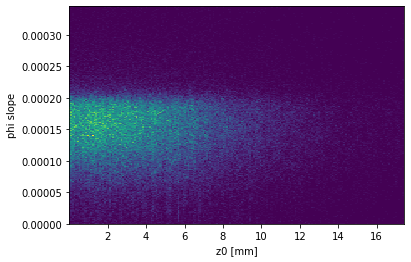

In [9]:
# Plot after cuts
plt.hist2d(z0_cut, phi_slope_cut, 200)
plt.xlabel("z0 [mm]")
plt.ylabel("phi slope")

In [10]:
# Calculate the truth edge purity
# Want this value close to .5

print("Initial Purity = " + str(len(y[y > 0])/len(y)))
y_cut = y[phi_slope < phi_value]
print("Purity after phi slope cut = " + str(len(y_cut[y_cut > 0])/len(y_cut)))
y_cut = y[z0 < z0_value]
print("Purity after z0 cut  = " + str(len(y_cut[y_cut > 0])/len(y_cut)))


y_cut   = y[phi_slope < phi_value]
z0_cut  = z0[phi_slope < phi_value]
phi_cut = phi_slope[phi_slope < phi_value]
y_cut2  = y_cut[z0_cut < z0_value]

print("Final Purity = " + str(len(y_cut2[y_cut2 > 0])/len(y_cut2)))

Initial Purity = 0.0031186212206319305
Purity after phi slope cut = 0.37992058488458263
Purity after z0 cut  = 0.11677208756495742
Final Purity = 0.9492607358722427


In [13]:
# Find the phi cut value that balances the true and false edges

threshold = .5
fraction = 0
cut = .001
while (fraction < threshold):
    cut -= .000001
    y_balance  = y[phi_slope < cut]
    phi_slope_balance = phi_slope[phi_slope < cut]
    fraction = len(phi_slope_balance[y_balance > 0]) / len(phi_slope_balance)
    print(cut, fraction)
balance_value = cut

0.000999 0.17576433972371047
0.0009980000000000002 0.1758984891162047
0.0009970000000000003 0.17604861625109572
0.0009960000000000004 0.1761915824524722
0.0009950000000000004 0.1763314236999843
0.0009940000000000005 0.17648199519490831
0.0009930000000000006 0.17662621017084884
0.0009920000000000007 0.17678385394036117
0.0009910000000000008 0.17693073531503342
0.0009900000000000009 0.17707441557537204
0.000989000000000001 0.1772301359697763
0.000988000000000001 0.1773797617032626
0.0009870000000000011 0.17752581278047047
0.0009860000000000012 0.17767582369593252
0.0009850000000000013 0.17782364386525654
0.0009840000000000014 0.17796548242576066
0.0009830000000000015 0.1781183720012732
0.0009820000000000015 0.17827060553137353
0.0009810000000000016 0.17840892441854467
0.0009800000000000017 0.1785585206021516
0.0009790000000000018 0.1787026424820667
0.0009780000000000019 0.17885199187012893
0.000977000000000002 0.17901019209168223
0.0009760000000000019 0.17915578764142734
0.00097500000000

0.0007989999999999976 0.21041475675484828
0.0007979999999999976 0.2106206661223296
0.0007969999999999976 0.21082318728141922
0.0007959999999999976 0.21102532763035312
0.0007949999999999975 0.21123321123321123
0.0007939999999999975 0.21143969404758117
0.0007929999999999975 0.21165824493165045
0.0007919999999999975 0.2118705675389076
0.0007909999999999974 0.21207856034064904
0.0007899999999999974 0.21229459967742767
0.0007889999999999974 0.21250630172021592
0.0007879999999999974 0.21272183012778695
0.0007869999999999973 0.21293367815256403
0.0007859999999999973 0.2131500760351698
0.0007849999999999973 0.21336796789060483
0.0007839999999999973 0.21358419399847497
0.0007829999999999972 0.2138000653187257
0.0007819999999999972 0.21402361624530183
0.0007809999999999972 0.2142405549742893
0.0007799999999999972 0.21445296940321565
0.0007789999999999971 0.2146723873218092
0.0007779999999999971 0.21488709033643486
0.0007769999999999971 0.2151090930137902
0.0007759999999999971 0.2153206504336515


0.0006009999999999928 0.26152552643538857
0.0005999999999999928 0.2618496873099249
0.0005989999999999928 0.2621814255187633
0.0005979999999999927 0.26250802137411083
0.0005969999999999927 0.2628386371837445
0.0005959999999999927 0.26315685171550135
0.0005949999999999927 0.2634564581384311
0.0005939999999999926 0.2637626418894038
0.0005929999999999926 0.2640766480696478
0.0005919999999999926 0.2644160220571341
0.0005909999999999926 0.2647255027350813
0.0005899999999999925 0.26504131698464317
0.0005889999999999925 0.26536786487870045
0.0005879999999999925 0.26568223654642953
0.0005869999999999925 0.2660080226965568
0.0005859999999999925 0.26633185212614946
0.0005849999999999924 0.26667016842424
0.0005839999999999924 0.26701213522773853
0.0005829999999999924 0.2673515758952842
0.0005819999999999924 0.2676842005685246
0.0005809999999999923 0.2679984039026753
0.0005799999999999923 0.26833336701556276
0.0005789999999999923 0.2686784852055532
0.0005779999999999923 0.26902461490984303
0.000576

0.000402999999999988 0.34515607706004076
0.000401999999999988 0.3456819875127774
0.00040099999999998795 0.34625311042225304
0.00039999999999998793 0.3468099896235254
0.0003989999999999879 0.34737795968451557
0.0003979999999999879 0.3479686631286328
0.00039699999999998786 0.3485193345105218
0.00039599999999998783 0.34909189009375213
0.0003949999999999878 0.3496533901128819
0.0003939999999999878 0.3502615350171982
0.00039299999999998776 0.35081389067261926
0.00039199999999998774 0.35141509915598457
0.0003909999999999877 0.35199996727065935
0.0003899999999999877 0.35258921692375783
0.00038899999999998766 0.35318168942967276
0.00038799999999998764 0.35377956884233036
0.0003869999999999876 0.35434218953689767
0.0003859999999999876 0.3549129704730825
0.00038499999999998757 0.3554771354723008
0.00038399999999998754 0.35606002595247016
0.0003829999999999875 0.35665125728145275
0.0003819999999999875 0.3572509858400354
0.00038099999999998747 0.35785650543237457
0.00037999999999998744 0.358403806

0.00020699999999998427 0.4917572919762484
0.00020599999999998427 0.4922066419316449
0.00020499999999998427 0.49255414403980086
0.00020399999999998428 0.492870602822296
0.00020299999999998428 0.49316736488090285
0.00020199999999998428 0.49332243371203327
0.00020099999999998429 0.4934551879456009
0.0001999999999999843 0.4935723327446905
0.0001989999999999843 0.49356328338516636
0.0001979999999999843 0.49337576882759315
0.0001969999999999843 0.49318413473598643
0.0001959999999999843 0.492959275902487
0.0001949999999999843 0.4925517905893689
0.0001939999999999843 0.4921487282878412
0.0001929999999999843 0.49165899920995393
0.0001919999999999843 0.49113094011053193
0.00019099999999998431 0.49036494956048626
0.00018999999999998432 0.4895216876697069
0.00018899999999998432 0.4887461524594214
0.00018799999999998432 0.4878439017831633
0.00018699999999998433 0.4868470506174386
0.00018599999999998433 0.48581009855661805
0.00018499999999998433 0.48493014143566654
0.00018399999999998433 0.483923898

1.199999999998475e-05 0.11596887736198593
1.099999999998475e-05 0.11231407467368208
9.999999999984749e-06 0.11203827325322653
8.999999999984749e-06 0.10901001112347053
7.999999999984748e-06 0.1067298314058799
6.999999999984748e-06 0.10652208579173976
5.9999999999847485e-06 0.10545859636093576
4.999999999984749e-06 0.10307657758814283
3.999999999984749e-06 0.099601593625498
2.9999999999847492e-06 0.0998109640831758
1.9999999999847495e-06 0.10476718403547672
9.999999999847496e-07 0.11672278338945005


ZeroDivisionError: division by zero

In [ ]:
print('Using cut phi slope < ' + str(balance_value))
y_balance   = y[phi_slope < balance_value]
phi_balance = phi_slope[phi_slope < balance_value]

print('True Edge Efficiency = ' + str(len(phi_balance[y_balance > 0])/len(phi_slope[y > 0])))
print("True Edge Fraction = " + str(len(phi_balance[y_balance > 0])/len(phi_balance)))